Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from collections import Counter

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 160)


Loading the dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/diabetes.csv")

print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Basic EDA (info, statistics, missing values)

In [ ]:
# Display basic information about the dataset (columns, data types, non-null counts)
df.info()

# Show statistical summary of all numeric columns
df.describe()

# Print number of missing values in each column
print("\nMissing values per column:")
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB

Missing values per column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Ag

Common diabetes dataset columns where zero = missing:

Glucose

BloodPressure

SkinThickness

Insulin

BMI

In [ ]:
# Columns where a value of zero is not valid (treated as missing data)
cols_zero_invalid = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Replace zeros with NaN in those columns
for col in cols_zero_invalid:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)

# Show how many missing values each column has after replacement
print("Missing values after replacing zeros:\n")
print(df.isnull().sum())


Missing values after replacing zeros:

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


Impute missing values

In [ ]:
# Fill all missing values in each column using the column's median
for col in df.columns:
    df[col].fillna(df[col].median(), inplace=True)

# Check that no missing values remain
print("Missing after imputation:\n", df.isnull().sum())


Missing after imputation:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


/tmp/ipython-input-856633183.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


Split into features and labels

In [ ]:
X = df.drop(columns=['Outcome']).values
y = df['Outcome'].values

print(X.shape, y.shape)


(768, 8) (768,)


Train-test split (WITHOUT sklearn)

70% train, 30% test.

In [ ]:
def train_test_split_scratch(X, y, test_size=0.3, seed=42):
    np.random.seed(seed)
    idx = np.arange(len(X))
    np.random.shuffle(idx)

    test_n = int(len(X) * test_size)
    test_idx = idx[:test_n]
    train_idx = idx[test_n:]

    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = train_test_split_scratch(X, y)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (538, 8) Test: (230, 8)


Implement Euclidean distance

In [ ]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

# quick check
print(euclidean_distance(np.array([3,4]), np.array([0,0])))  # should be 5


5.0


Implement kNN (single prediction + batch prediction)

In [ ]:
def knn_predict_single(x, X_train, y_train, k=3):
    distances = np.linalg.norm(X_train - x, axis=1)
    neighbors = np.argsort(distances)[:k]
    labels = y_train[neighbors]
    return np.bincount(labels).argmax()

def knn_predict(X_test, X_train, y_train, k=3):
    return np.array([knn_predict_single(x, X_train, y_train, k) for x in X_test])


Compute accuracy

In [ ]:
def accuracy(y_true, y_pred):
    return (y_true == y_pred).mean() * 100


Evaluate baseline model (“no scaling”)

In [ ]:
start = time.time()
preds = knn_predict(X_test, X_train, y_train, k=3)
t = time.time() - start

print("Accuracy:", accuracy(y_test, preds))
print("Time:", t)


Accuracy: 67.82608695652173
Time: 0.015759944915771484


Apply Z-score scaling

In [ ]:
def zscore_fit(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    std[std == 0] = 1  # avoid divide by zero
    return mean, std

def zscore_transform(X, mean, std):
    return (X - mean) / std

mean, std = zscore_fit(X_train)
X_train_scaled = zscore_transform(X_train, mean, std)
X_test_scaled = zscore_transform(X_test, mean, std)


Evaluate scaled model

In [ ]:
# Measure prediction time for scaled data
start = time.time()                   # start timer
preds_scaled = knn_predict(X_test_scaled, X_train_scaled, y_train, k=3)
t_scaled = time.time() - start        # end timer

# Print accuracy and time taken
print("Scaled Accuracy:", accuracy(y_test, preds_scaled))
print("Scaled Time:", t_scaled)


Scaled Accuracy: 67.3913043478261
Scaled Time: 0.013709068298339844


Experiment with k = 1 to 15

In [ ]:
# Lists to store accuracy values for each k (1 to 15)
accs_orig = []      # accuracy values without scaling
accs_scaled = []    # accuracy values with z-score scaling

# Try different values of k
for k in range(1, 16):

    # ---- ORIGINAL DATA ----
    # Predict using kNN on the unscaled (original) training & test data
    pred = knn_predict(X_test, X_train, y_train, k)

    # Compute accuracy and store it
    accs_orig.append( accuracy(y_test, pred) )

    # ---- SCALED DATA ----
    # Predict using kNN on the scaled training & test data
    pred_s = knn_predict(X_test_scaled, X_train_scaled, y_train, k)

    # Compute accuracy and store it
    accs_scaled.append( accuracy(y_test, pred_s) )

# Print the accuracy lists for comparison
print("Original Accuracies:", accs_orig)
print("Scaled Accuracies:", accs_scaled)



Original Accuracies: [np.float64(67.3913043478261), np.float64(70.0), np.float64(67.82608695652173), np.float64(70.43478260869566), np.float64(67.3913043478261), np.float64(70.0), np.float64(70.86956521739131), np.float64(69.1304347826087), np.float64(70.86956521739131), np.float64(71.73913043478261), np.float64(70.86956521739131), np.float64(70.43478260869566), np.float64(72.17391304347827), np.float64(70.86956521739131), np.float64(70.86956521739131)]
Scaled Accuracies: [np.float64(66.52173913043478), np.float64(67.3913043478261), np.float64(67.3913043478261), np.float64(69.1304347826087), np.float64(70.43478260869566), np.float64(67.82608695652173), np.float64(72.60869565217392), np.float64(73.04347826086956), np.float64(73.04347826086956), np.float64(71.30434782608695), np.float64(71.30434782608695), np.float64(73.04347826086956), np.float64(75.65217391304347), np.float64(73.47826086956522), np.float64(73.47826086956522)]


Ploting the results

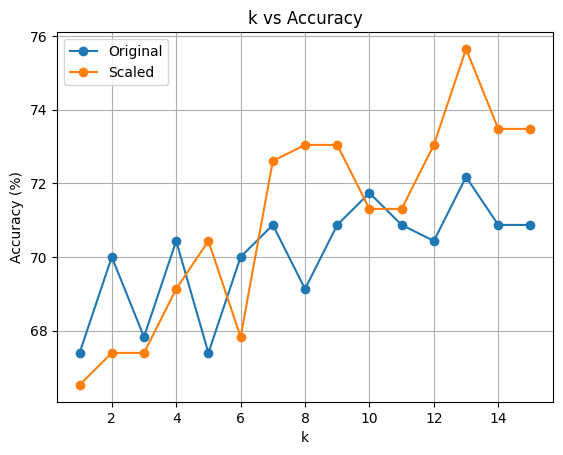

In [ ]:
plt.plot(range(1,16), accs_orig, marker='o', label="Original")
plt.plot(range(1,16), accs_scaled, marker='o', label="Scaled")
plt.xlabel("k")
plt.ylabel("Accuracy (%)")
plt.title("k vs Accuracy")
plt.legend()
plt.grid(True)
plt.show()
